In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
sheet_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
url = 'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_id}'.format(sheet_id=sheet_id)
df = pd.read_csv(url)

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294.00,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.50,38.81M,-0.02%
2,"Mar 29, 2021",293.30,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.50,287.03,283.85,35.22M,0.30%


In [4]:
df.shape

(311, 7)

In [5]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [6]:
df.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.76%
2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.02%
2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.71%
2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%
2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.30%


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
def remove_string(data, column, item):
  data[column] = df[column].str.replace(item, '').astype(float)
  return data[column].dtype

In [11]:
remove_string(df, 'Change %', '%')
remove_string(df, 'Vol.', 'M')


dtype('float64')

In [12]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.76
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.02
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.71
2021-03-26,291.22,288.63,292.75,288.32,56.07,1.59
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.30


In [13]:
y = df['Price']

In [14]:
type(y)

pandas.core.series.Series

In [15]:
y.describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

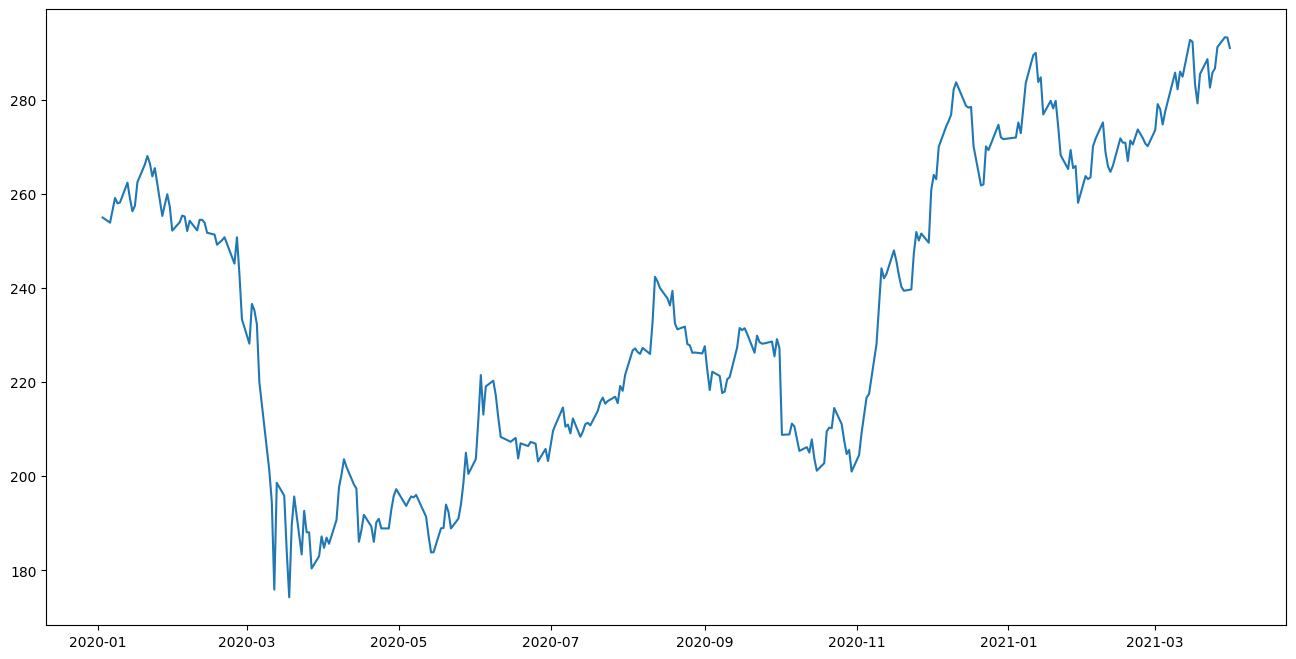

In [16]:
plt.figure(figsize=(16, 8))
plt.plot(y)
plt.show()

In [17]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
seasonal = decomp.seasonal
trend = decomp.trend
residual = decomp.resid

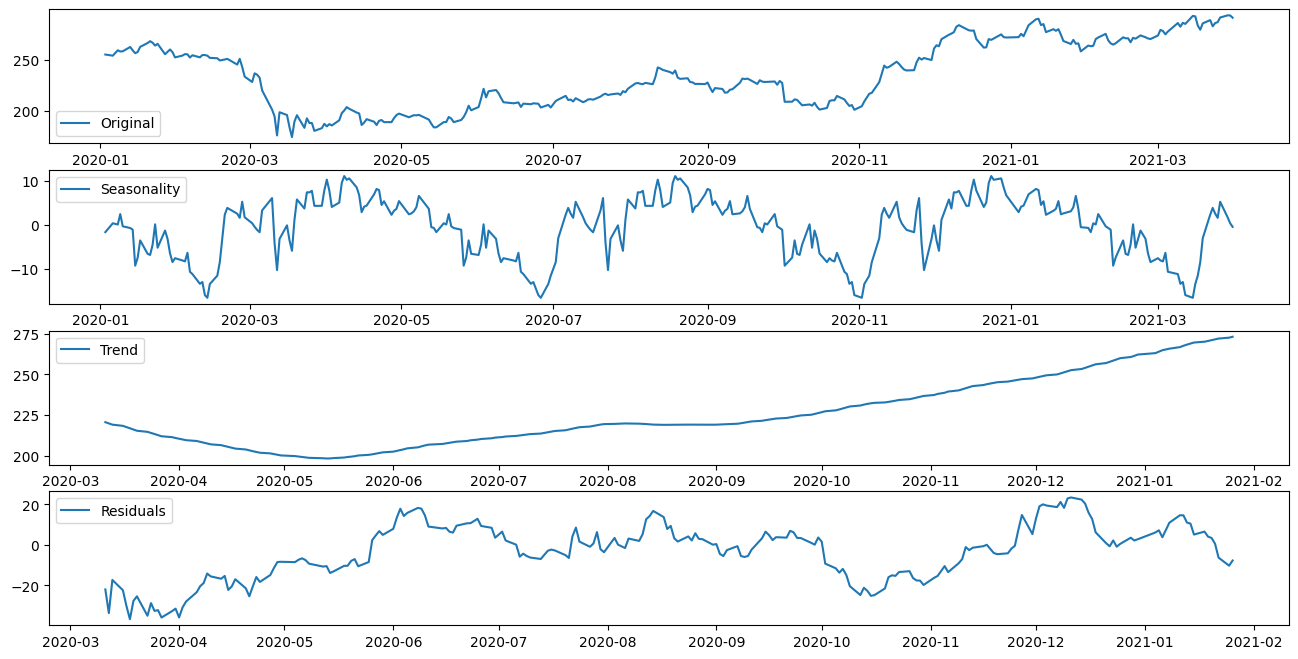

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['Price'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.show()

## Testing For Stationarity

In [38]:
from statsmodels.tsa.stattools import kpss
kpss_stat, p_value, n_lags, critical_value = kpss(df['Price'])
def stationarity_check(value):
    if value < 0.05:
        print("Data is not stationary")
    else:
        print("Data is stationary")
stationarity_check(p_value)

Data is not stationary


In [20]:
df['rolling_mean'] = df['Price'].rolling(window=5).mean()

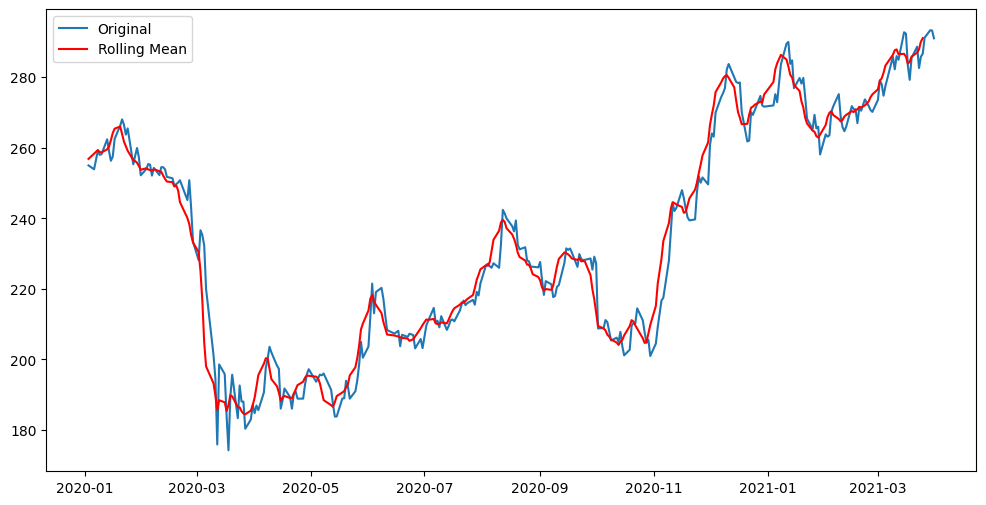

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df['Price'], label='Original')
plt.plot(df['rolling_mean'], color='red', label='Rolling Mean')
plt.legend()
plt.show()


In [22]:
df['mean_diff'] = df['rolling_mean'].diff()
df = df.dropna()

In [23]:
df.head()

,Price,Open,High,Low,Vol.,Change %,rolling_mean,mean_diff
Date,,,,,,,,
2021-03-24,285.79,283.40,288.00,282.25,46.41,1.13,290.044,-1.046
2021-03-23,282.60,287.56,288.30,282.11,70.76,-2.10,287.914,-2.130
2021-03-22,288.65,285.00,291.20,283.08,62.76,1.11,286.984,-0.930
2021-03-19,285.47,279.00,286.31,278.03,84.25,2.23,285.834,-1.150
2021-03-18,279.25,284.04,285.79,278.24,74.13,-1.45,284.352,-1.482


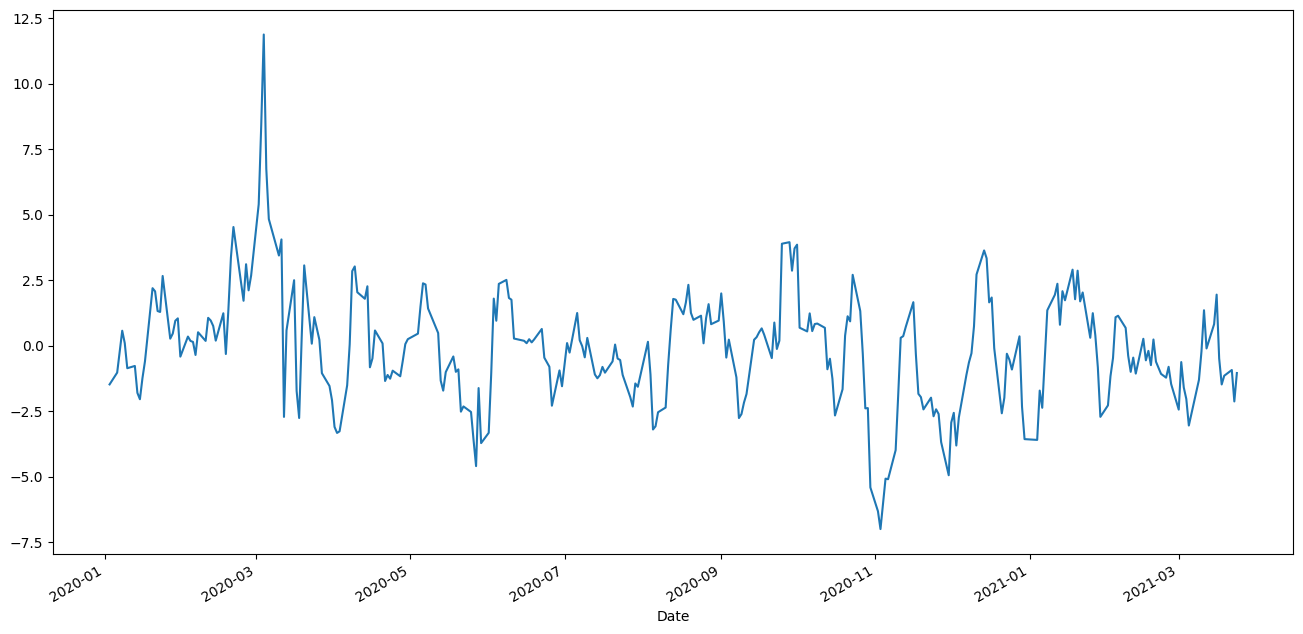

In [24]:
df['mean_diff'].plot(figsize=(16, 8))
plt.show()

In [25]:
stationarity_check(kpss(df['mean_diff'])[1])

Data is stationary


In [26]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [27]:
df_2020 = df.loc['2020-01-01':]
df_2021 = df.loc['2021-01-01':]


In [28]:
def evaluate_arima_model(data, arima_order):
  train, test = df_2020, df_2021
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    future = model_fit.forecast()[0]
    predictions.append(future)
    history.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

In [29]:
def evaluate_model(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order,mse))
        except:
          continue
  return print("Best ARIMA%s MSE=%.3f" % (best_cfg, best_score))

In [30]:
p_values = [x for x in range(0, 100)]
d_values = [x for x in range(0, 100)]
q_values = [x for x in range(0, 100)]

In [31]:
#evaluate_model(df['mean_diff'], p_values, d_values, q_values)

In [39]:
p = 2
d = 1
q = 1
model = ARIMA(df['mean_diff'], order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(len(df_2021))

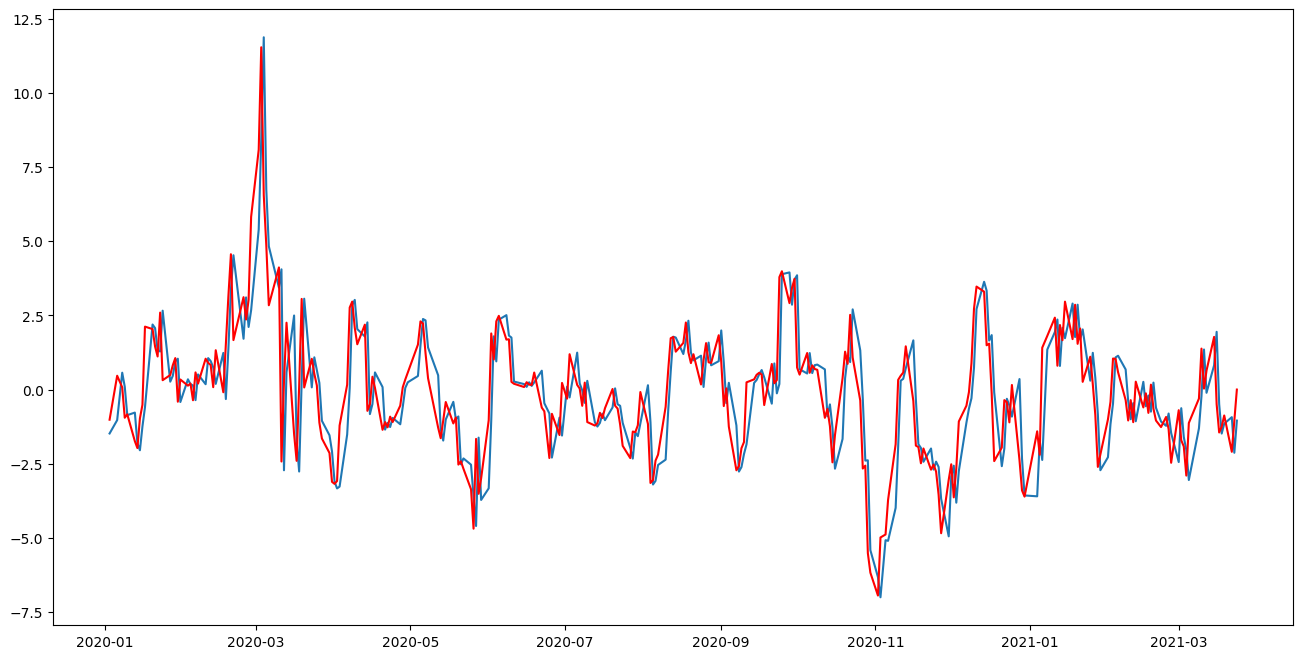

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(df['mean_diff'], label='Original')
plt.plot(model_fit.predict(), color='red', label='Forecast')

In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              mean_diff   No. Observations:                  306
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -522.285
Date:                Fri, 17 Nov 2023   AIC                           1052.571
Time:                        13:04:11   BIC                           1067.452
Sample:                             0   HQIC                          1058.523
                                - 306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0728      0.493     -0.148      0.883      -1.039       0.893
ar.L2         -0.0907      0.045     -2.018      0.044      -0.179      -0.003
ma.L1          0.0397      0.512      0.077      0.938      -0.964       1.043
sigma2         1.7984      0.104     17.277      0.000       1.594       2.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                71.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:

print("Length of forecast:", len(forecast))
print("Length of df_2021:", len(df_2021))


Length of forecast: 56
Length of df_2021: 56


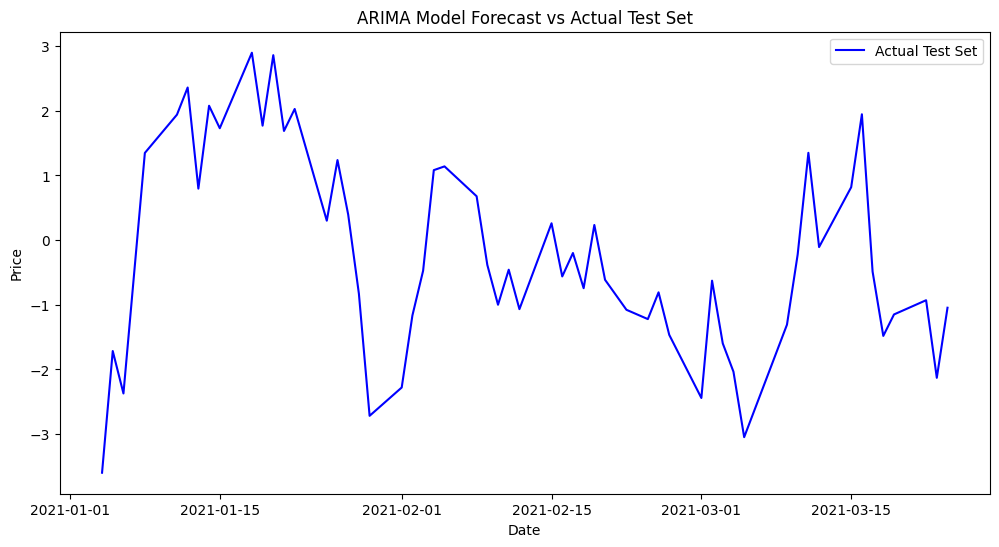

In [36]:
plt.figure(figsize=(12,6))

# Plot the actual test set values
plt.plot(df_2021['mean_diff'], label='Actual Test Set', color='blue')

# Plot the forecasted values
#plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [43]:
forecast_df = pd.DataFrame(forecast)
forecast_df.columns = ['mean_diff']
forecast_df.index = df_2021.index
forecast_df.head()

,mean_diff
Date,
2021-03-24,-1.320647
2021-03-23,-1.291420
2021-03-22,-1.308008
2021-03-19,-1.309452
2021-03-18,-1.307841
